In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
import seaborn as sns
import pickle


In [3]:
data = pd.read_csv("laptop_dataset.csv") 

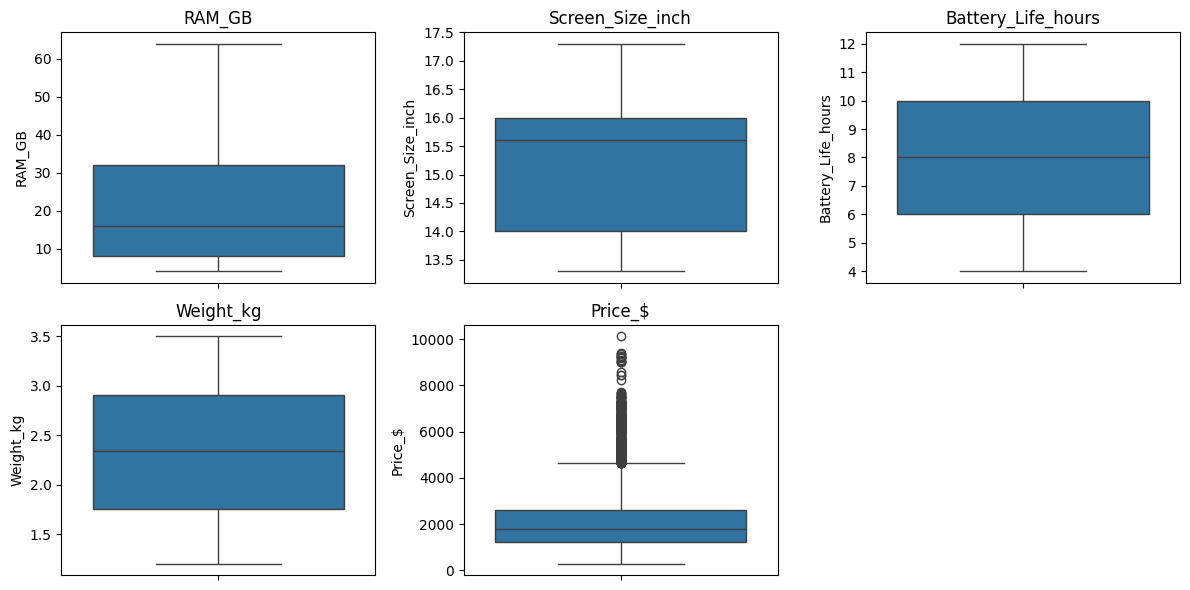

In [4]:
numeric_features = ["RAM_GB", "Screen_Size_inch", "Battery_Life_hours", "Weight_kg", "Price_$"]
plt.figure(figsize=(12, 6))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

In [5]:
for _ in range(2):
    Q1 = data["Price_$"].quantile(0.25)
    Q3 = data["Price_$"].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data = data[(data["Price_$"] >= lower_bound) & (data["Price_$"] <= upper_bound)]


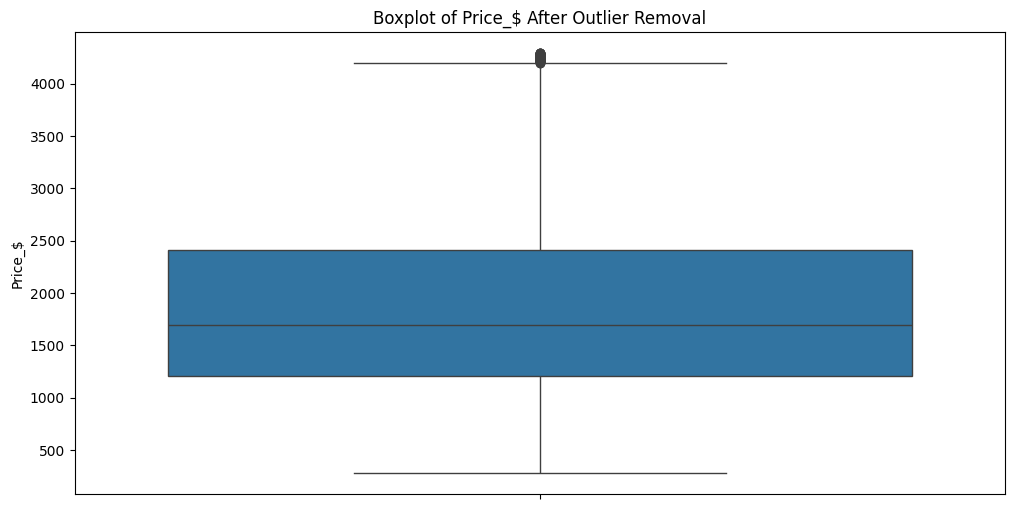

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(y=data["Price_$"])
plt.title("Boxplot of Price_$ After Outlier Removal")
plt.show()


In [7]:
data_encoded = pd.get_dummies(data, columns=["Brand", "Processor", "Storage", "GPU", "Resolution", "Operating_System"], dtype=int)


In [8]:
scaler = MinMaxScaler()
numeric_features = ["RAM_GB", "Screen_Size_inch", "Battery_Life_hours", "Weight_kg"]
data_encoded[numeric_features] = scaler.fit_transform(data_encoded[numeric_features])

In [9]:
X = data_encoded.drop(columns=["Price_$"])
y = data_encoded["Price_$"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [37]:
param_dist = {
    "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5],
    "n_estimators": [100, 150, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800],
    "max_depth": [3, 5, 7, 10, 12, 15],
    "reg_lambda": [0, 0.1, 0.5, 1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 0.5, 1, 5, 10, 20],
    "subsample": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
}

xgb = XGBRegressor(random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)

max_err = max_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Najbolji hiperparametri:", random_search.best_params_)
print("Max error:", max_err)
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R-squared:", r2)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Najbolji hiperparametri: {'subsample': 1.0, 'reg_lambda': 20, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.5, 'colsample_bytree': 1.0}
Max error: 327.0283276367188
Mean Absolute Error: 85.58935101557044
Mean Squared Error: 10833.05988804981
R-squared: 0.9847256851290669


In [10]:
model = XGBRegressor(
    learning_rate=0.5,     
    n_estimators=300,       
    max_depth=3,
    reg_lambda=20,  
    reg_alpha=0.1,  
    subsample=1,   
    colsample_bytree=1.0,    
)
model.fit(X_train, y_train)

predictions = model.predict(X_test)

In [ ]:
import pickle

with open("laptop_price_model.pkl", "wb") as f:
    pickle.dump(model, f)

In [18]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)